# A Self-Connected Cluster of N-1 neurons with N-2 self connections gets an input perturbation from 1 Neuron

In [13]:
import numpy as np
import pylab as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
from mpl_toolkits import mplot3d

In [14]:
TAU_TWO = 0.3
TAU_FALL= 0.45
THRESHOLD= -30.0
INCREMENT =100 

CM  = 1.00  # /*uF/cm2*/
I_APP = 0.00 # /*uA/cm2*/

E_NA =  50.0
E_K  = -90.0
E_L  = -71.975 # //-70.4
E_SYN_SH =  -55.0 #reversal potential of GABA_Asynapse - determines shunt (-55) 
E_SYN_H =  -75.0 #reversal potential of GABA_Asynapse - determines hyperpolarizing (-75) 
#E_SYN =  -75.0 #reversal potential of GABA_Asynapse - determines shunt (-55) versus hyperpolarizing (-75) 

G_NA = 218.8 # //239.13  mS/cm2 all conductances were divided by 0.000096 cm2
G_K3 =  8.225 # // 10.22469
G_K1 =  0.769 # // 1.1058
G_L  = 0.1915 # // 0.2224

#DELAY = 0.8

THETA_M = -52.995 # // -56.42
SIGMA1_M = 4.0
SIGMA2_M = -13.0
K1_M = 0.25
K2_M = 0.1

THETA_H = -55.711 # //-56.59
SIGMA1_H = -20.0
SIGMA2_H = 3.5
K1_H = 0.012
K2_H = 0.2

THETA_N = 5.9 # // -4.23
SIGMA1_N = 12.0
SIGMA2_N = -8.5
K1_N = 1.0 
K2_N = 0.001

THETA_A = 51.355 # // 51.4
SIGMA1_A = 12.0
SIGMA2_A = -80.0
K1_A = 1.0 
K2_A = 0.02

ALPHA = 6.25 # /* ms */
TAUSYN = 1.0 # /*  1.0 3.0 2.0   */
SS1 = 0.00
SS2 = 0.00
I_STIM = 0.0

#Defining some functions that are required for the routine

def boltz(V,half,slope): 
    arg = -(V-half)/slope
    if( (arg>50.0) or (arg<-50) ):
        if(arg>50):
            return(0.0)
        else:
            return(1.0)
    else:
        return(1.0/(1.0 + np.exp(arg)))

def gaussian(v,a,b,c,d):
    arg = ((v-c)/b)**2
    if( (arg>50.0) or (arg<-50) ):
        if(arg>50):
            return(d)
        else:
            return(d+a)
    else:
        return((d + a*np.exp(-arg)))

def efun(z):
    if(abs(z) < 1e-4):
        return(1 - z/2)
    else:
        return(z/(np.exp(z) - 1))
    
def alpha(v,k,theta,sigma):
    arg = (theta-v)/sigma
    if(v == theta):
        return(k*sigma)
    else:
        if( (arg>50.0) or (arg<-50) ):
            if(arg>50.0): 
                return(0.0)
            else:
                return(k*(v - theta))
        else:
            return(k*(theta-v)/(np.exp(arg) - 1.0))

def beta(v,k,sigma):
    return(k*np.exp(v/sigma))

#This function identifies the onset of a spike, the first time the threshold is crossed
def spike(x,t):
    'An event when V1 >= THRESHOLD'
    if (t == 0.0):
        return 0
    
    if (x[0] >= THRESHOLD):
        return 1
    else:
        return 0
    
#Functions for Synaptic Currents 
def I_NA(V, M, H): return G_NA * (M**3) * H * (V - E_NA)
def I_K1(V,A): return G_K1 * (A**4) * (V - E_K)
def I_L(V): return G_L * (V - E_L)
def I_K3(V,N): return G_K3 * (N**4) * (V - E_K)
def I_S1(V,gsyn1):   return gsyn1 * (V - E_SYN_H)
def I_S2(V):   return G_SYN2 * V
def I_S3(V,G): return G * (V - E_SYN_H)

In [15]:
def Euler_Via(intitial_values,tf,N,delta):
    e = [spike(initial_values[0],0)]
    #print(N)
    Autapse_Times = []
    t_autapse = -1
    gsyn1 = 0.0
    t = np.linspace(0,tf,N+1)
    dt = tf/N
    aut_prev = 0

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))
    A = np.zeros(len(t))
    M = np.zeros(len(t))
    X = np.zeros(len(t))
    G = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    H[0] = initial_values[1]
    N[0] = initial_values[2]
    A[0] = initial_values[3]
    M[0] = initial_values[4]
    X[0] = initial_values[5]
    G[0] = initial_values[6]
 
    sol = [initial_values]
    aut = []
    
    for i in range(len(t) - 1):
        if(round(t[i],3) == round(t_autapse,3)):
        #if(t[i] == t_autapse):
            #print(t[i],t_autapse)
            X[i] = X[i] + G_SYN3  
            
        V[i+1] = V[i] + ((dt*(I_STIM - I_S2(V[i]) - I_NA(V[i],M[i],H[i]) - I_K1(V[i],A[i]) - I_K3(V[i],N[i]) - I_L(V[i]) - I_S1(V[i],gsyn1) - I_S3(V[i],G[i]))) / CM)
        H[i+1] = H[i] + dt*(beta(V[i],K1_H,SIGMA1_H)*(1.0 - H[i]) - alpha(V[i],K2_H,THETA_H,SIGMA2_H)*H[i])
        N[i+1] = N[i] + dt*(alpha(V[i],K1_N,THETA_N,SIGMA1_N)*(1.0 - N[i]) - beta(V[i],K2_N,SIGMA2_N)*N[i])
        A[i+1] = A[i] + dt*(alpha(V[i],K1_A,THETA_A,SIGMA1_A)*(1.0 - A[i]) - beta(V[i],K2_A,SIGMA2_A)*A[i])
        M[i+1] = M[i] + dt*(alpha(V[i],K1_M,THETA_M,SIGMA1_M)*(1.0 - M[i]) - beta(V[i],K2_M,SIGMA2_M)*M[i])
        X[i+1] = X[i] + dt*(-X[i]/TAU_TWO)
        G[i+1] = G[i] + dt*(((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * X[i]) - G[i])/TAU_FALL)
        
        sol+=[[V[i+1],H[i+1],N[i+1],A[i+1],M[i+1],X[i+1],G[i+1]]]
        
        e += [spike(sol[-1],t[-1])]
        if ((e[-1]==1) and (e[-2] == 0)):
            t_autapse = t[i] + delta
            Autapse_Times.append(t_autapse)
            print(t_autapse-aut_prev)
            aut_prev= t_autapse
            aut += [t_autapse]
         
    return sol, aut

In [16]:
def Euler_Via_Perturb(intitial_values,tf,N,ts,delta):
    e = [spike(initial_values[0],0)]
    #print(N)
    Autapse_Times = []
    t_autapse = -1
    gsyn1 = 0.0
    t = np.linspace(0,tf,N+1)
    dt = tf/N

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))
    A = np.zeros(len(t))
    M = np.zeros(len(t))
    X = np.zeros(len(t))
    G = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    H[0] = initial_values[1]
    N[0] = initial_values[2]
    A[0] = initial_values[3]
    M[0] = initial_values[4]
    X[0] = initial_values[5]
    G[0] = initial_values[6]
 
    sol = [initial_values]
    
    arg = (TAU_TWO*TAU_FALL) * ((np.log(TAU_FALL/TAU_TWO))/(TAU_FALL-TAU_TWO))
    f = 1.0/(np.exp(-arg/TAU_FALL) - np.exp(-arg/TAU_TWO))
    
    for i in range(len(t) - 1):
        if (t[i] < ts): 
            gsyn1 = 0.0 #Allowing the first three spikes as a freely oscillating neuron 
        else:
            gsyn1 = f*G_SYN*(np.exp((ts - t[i])/TAU_FALL) - np.exp((ts - t[i])/TAU_TWO))

        if(round(t[i],3) == round(t_autapse,3)):
        #if(t[i] == t_autapse):
            print(t[i],t_autapse)
            X[i] = X[i] + G_SYN3  
            
        V[i+1] = V[i] + ((dt*(I_STIM - I_S2(V[i]) - I_NA(V[i],M[i],H[i]) - I_K1(V[i],A[i]) - I_K3(V[i],N[i]) - I_L(V[i]) - I_S1(V[i],gsyn1) - I_S3(V[i],G[i]))) / CM)
        H[i+1] = H[i] + dt*(beta(V[i],K1_H,SIGMA1_H)*(1.0 - H[i]) - alpha(V[i],K2_H,THETA_H,SIGMA2_H)*H[i])
        N[i+1] = N[i] + dt*(alpha(V[i],K1_N,THETA_N,SIGMA1_N)*(1.0 - N[i]) - beta(V[i],K2_N,SIGMA2_N)*N[i])
        A[i+1] = A[i] + dt*(alpha(V[i],K1_A,THETA_A,SIGMA1_A)*(1.0 - A[i]) - beta(V[i],K2_A,SIGMA2_A)*A[i])
        M[i+1] = M[i] + dt*(alpha(V[i],K1_M,THETA_M,SIGMA1_M)*(1.0 - M[i]) - beta(V[i],K2_M,SIGMA2_M)*M[i])
        X[i+1] = X[i] + dt*(-X[i]/TAU_TWO)
        G[i+1] = G[i] + dt*(((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * X[i]) - G[i])/TAU_FALL)
        
        sol+=[[V[i+1]]]
        
        e += [spike(sol[-1],t[-1])]
        if ((e[-1]==1) and (e[-2] == 0)):
            t_autapse = t[i] + delta
            Autapse_Times.append(t_autapse)
            #print('Autapse times',t_autapse)
         
    return sol

In [18]:
N = 25
G_SYN =   1*0.0214844 #single synapse value is 0.02391 mS/cm2*/ 
G_SYN2 =  0.09115 # // equal to 7 nS ChR*/ channel rhodopsin conductance
G_SYN3 =  (N-2)*0.0214844 # // autapse single synapse value
delta = 5.1

5.1
5.253120000000001
5.764320000000001
5.751359999999998
9.482399999999998
5.621760000000002
9.555840000000003
5.77872
7.2619200000000035
5.516639999999988
5.709600000000009
9.491039999999998
5.908320000000003
5.680799999999991
9.534239999999997
5.5800000000000125
5.748480000000001
9.482399999999998
5.974560000000011
6.494399999999985
5.84208000000001
6.788160000000005
5.555520000000001
9.771839999999997
5.667839999999984
5.696640000000002
9.557279999999992
-53.31033022625453 0.42174255572316016 0.31769204717949184 0.3834008622290966 0.12925546803477053 0.46649511238889024 0.21289494666704645
0.0 5.1
5.254560000000001 10.35312
11.018880000000001 16.117440000000002
16.77024 21.8688
26.252640000000003 31.3512
31.8744 36.97296
41.430240000000005 46.528800000000004
47.208960000000005 52.307520000000004
54.47088 59.56944000000001
59.98752 65.08608
65.69712 70.79568
75.18816000000001 80.28672
81.09648 86.19504
86.77728 91.87584
96.31152 101.41008
101.89152 106.99008
107.64 112.73856
117.122

Text(0.5, 0, 'N1')

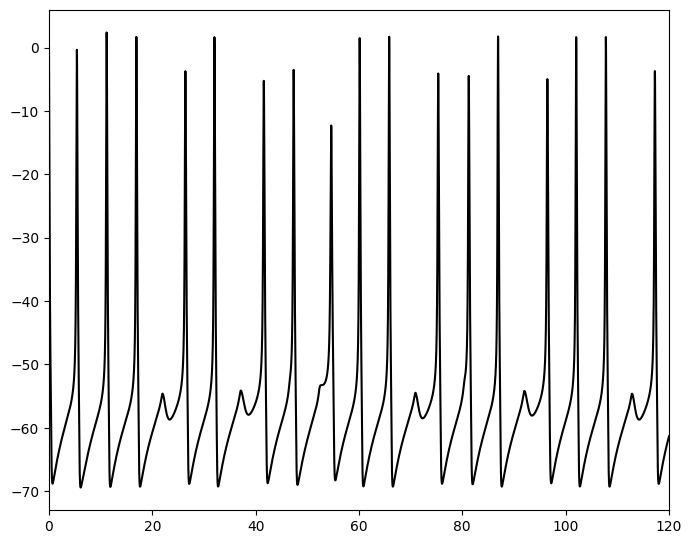

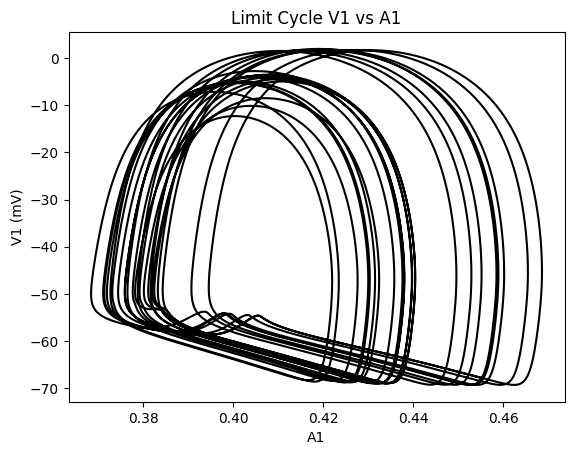

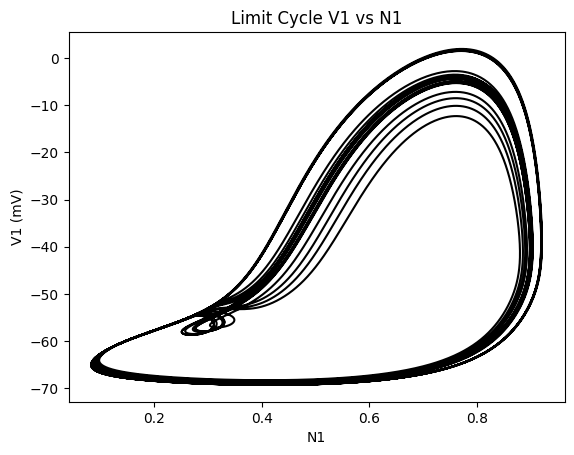

In [25]:
tf = 180
N = 125000
t = np.linspace(0,tf,N+1)
#delay_4 = np.linspace(5.0,5.9,9)
#delay_4 = np.around(delay_4,2)
#delay[0] = 0.01
#print(delay_4)

V1 = np.zeros(N+1)
H1 = np.zeros(N+1)
M1 = np.zeros(N+1)
X1 = np.zeros(N+1)
G1 = np.zeros(N+1)
N1 = np.zeros(N+1)
A1 = np.zeros(N+1)

free_running_single_4 = []

k = 0# k is the index of number of delays and it is a counter for free running numbers
#for delta in delay_4:
#initial_values = [-30.00000, 0.184178, 0.582675, 0.399928, 0.465379, 0.00, 0.00]
#initial_values = [-8.33750270, 0.24406642, 0.798152600, 0.377895026, 0.89545, 0.000, 0.00]
initial_values = [0.0, 0.02, 0.798152600, 0.377895026, 0.89545, 0.000, 0.00]
#initial_values = [-65.7152126, 0.3170107632, 0.09424784, 0.389294882, 0.008144255, 0.00, 0.00]
sol, Autapse_Times = Euler_Via(initial_values,tf,N,delta)
    #if (delta > 3):
    #    tf = 100
j = 0
i = 0
for i in range(len(sol)):
        #print('i of rows each time',sol[i][0])
    V1[j] = sol[i][0]
    H1[j] = sol[i][1]
    N1[j] = sol[i][2]
    A1[j] = sol[i][3]
    M1[j] = sol[i][4]
    X1[j] = sol[i][5]
    G1[j] = sol[i][6]
        #print(T[j],V1[j])
    j = j+1

print(V1[36500],H1[35500],N1[36500],A1[36500],M1[36500],G1[36500],X1[36500])
itemindex = np.where(V1[:] >= THRESHOLD)
    #print(itemindex)

for index in itemindex:
    spike_times = t[index]
    
    #print(spike_times)

previous = spike_times[0]
actual_spikes = []
actual_spikes.append(previous)   
for i in range(len(spike_times)):
    if (spike_times[i] - previous > 1 ):
        actual_spikes.append(spike_times[i])
    previous = spike_times[i]

free_running_self_4 = actual_spikes

for j in range(len(free_running_self_4)):
    print(free_running_self_4[j],Autapse_Times[j])


plt.figure(figsize=(8,6.5))
#plt.title('Voltage Trace for Self-Connected with Delay = 4.8 ms')
plt.plot(t,V1, 'k', label='V1')
#plt.ylabel('V1 (mV)')
#plt.xlabel('Time (mS)')
plt.xlim([0, 120])
plt.savefig('Voltage_Trace5P1.eps', format='eps')

plt.figure()
plt.title('Limit Cycle V1 vs A1')
plt.plot(A1[12500:],V1[12500:], 'k', label='V1')
plt.ylabel('V1 (mV)')
plt.xlabel('A1')
#plt.savefig('LC31_4P8.png', format='png')

plt.figure()
plt.title('Limit Cycle V1 vs N1')
plt.plot(N1[12500:],V1[12500:], 'k', label='V1')
plt.ylabel('V1 (mV)')
plt.xlabel('N1')
#plt.savefig('Trace_5P1.eps', format='eps')

In [23]:
T1 = free_running_self_4[7]
T2 = free_running_self_4[8]
#free_running_period = T2-T1
#print(free_running_period)
period_free_single = T2 - T1
print(period_free_single)
epsilon = 0.01
#prc_interval = np.arange(T1+epsilon, T2-epsilon, epsilon)
prc_interval_single = np.linspace(T1+epsilon, T2, 100)
stim_interval = prc_interval_single - T1
#print(prc_interval_single)
phase_single = stim_interval/period_free_single

prc_readings_single = np.zeros((len(prc_interval_single),1))
output_single = np.zeros((len(prc_interval_single),2))

j=0
for ts in prc_interval_single:
    tf = 80
    N = 40000
    #print(ts)
    t = np.linspace(0,tf,N+1)
    
    initial_values = [-30.00000, 0.184178, 0.582675, 0.399928, 0.465379, 0.00, 0.00]
    sol = Euler_Via_Perturb(initial_values,tf,N,ts,delta)

    V1 = np.zeros(N+1)

    k = 0
    for i in range(len(sol)):
        #print('i of rows each time',sol[i][0])
        V1[k] = sol[i][0]
        #print(T[j],V1[j])
        k = k+1
    
    itemindex = np.where(V1[:] > THRESHOLD)
    
    for index in itemindex:
        spike_times = t[index]
        
    previous = spike_times[0]
    actual_spikes = []
    actual_spikes.append(previous)   
    for i in range(len(spike_times)):
        if (spike_times[i] - previous > 1 ):
            actual_spikes.append(spike_times[i])
        previous = spike_times[i]
    #print(j,ts,actual_spikes)
    #diff_timings = np.zeros(len(actual_spikes))
    #for p in range(len(actual_spikes) - 1):
        #print(p,actual_spikes[p+1] - actual_spikes[p],free_running_self[p+1] - free_running_self[p])
    diff_timings = (actual_spikes[8] - actual_spikes[7]) - (free_running_self_4[8] - free_running_self_4[7])
    #print(diff_timings,diff_timings.shape)

    
    #print(phase_self[j],diff_timings[2:5]/period_free)
    #prc_readings.append(diff_timings)
    prc_readings_single[j,:] = diff_timings
    output_single[j,0] = phase_single[j]
    output_single[j,1:] = diff_timings/9.5349
    print(output_single[j,:])
    j = j+1

prc_readings_single = prc_readings_single/9.5349
#print('The final readings required for the PRC are:',prc_readings_36)
#print(prc_readings.shape)
#print(phase.shape

#df = pd.DataFrame(output_single, columns=['Phase', 'First_Order', 'Second_Order', 'Third_Order'])
#df.to_excel('02. PRC_Self2Single_Hyper.xlsx', sheet_name='Network Perturbation')

7.261919999999996
5.1000000000000005 5.1
14.558 14.558
20.792 20.792
26.900000000000002 26.9
33.072 33.072
39.14 39.14
45.322 45.322
51.366 51.366
58.662 58.662
64.29 64.28999999999999
77.108 77.10799999999999
[0.00137705 0.00357424]
5.1000000000000005 5.1
14.558 14.558
20.792 20.792
26.900000000000002 26.9
33.072 33.072
39.14 39.14
45.322 45.322
51.366 51.366
59.006 59.006
64.592 64.592
77.426 77.426
[0.01146415 0.03965222]
5.1000000000000005 5.1
14.558 14.558
20.792 20.792
26.900000000000002 26.9
33.072 33.072
39.14 39.14
45.322 45.322
51.366 51.366
60.052 60.052
65.554 65.554
73.06400000000001 73.064
78.628 78.628
[0.02155125 0.14935448]
5.1000000000000005 5.1
14.558 14.558
20.792 20.792
26.900000000000002 26.9
33.072 33.072
39.14 39.14
45.322 45.322
51.366 51.366
63.942 63.942
69.412 69.41199999999999
76.044 76.044
[0.03163835 0.55732939]
5.1000000000000005 5.1
14.558 14.558
20.792 20.792
26.900000000000002 26.9
33.072 33.072
39.14 39.14
45.322 45.322
51.366 51.366
63.234 63.234
68

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(output_single, columns=['Phase', 'First_Order'])
df.to_excel('48.Single2Self4P8.xlsx', sheet_name='Single2Self_1to24')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
#plt.title('PRCs for Single due to Network with delay of 5.1ms')
plt.plot(phase_single, prc_readings_single, 'bo', label='1st Order')
#plt.axvline(x = (5.7/5.9),color='k',linestyle='--')
plt.ylabel('Phase Resetting')
plt.xlabel('Phase')
plt.savefig('PRC_Single4P8.eps', format='eps')
plt.legend()


ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlim([0, 1])





